# The Outcasts of Hollywood 
### Ada CS-401 Project 
### Autumn 2022 - xxdatasiencesxx

#### SUMMARY: 
1. NLP (question 1 and 2)
1. Genders and ethnicities of the actors (question 3)
    1. Movie revenue distribution in main character database versus cmu movies
    1. Genre distribution in cmu database versus main character database
    1. Are movies genres and gender of the lead role related?
    1. Adding the ethnicity of actors (when available)
1. Gender of the crew (question 5)
    1. Data preprocessing
    1. Are the proportions of movies with women in the crew or created by men different ? 
    1. Does the proportion of movies with women in the crew change with time ?
1. Revenue comparisons (question 4)
    1. In terms of the gender of the main actor
    1. In terms of the gender of the crew 
    1. OLS to predict the revenue

# 0 - Data Wrangling

In [117]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import gzip
import glob, os
from tqdm.auto import tqdm
tqdm.pandas()
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.formula.api as smf

import plotly.graph_objects as go
import plotly.express as px
import chart_studio
import chart_studio.tools as tls
import chart_studio.plotly as py

path = '../MovieSummaries/'

In [ ]:
# Load various datasets
movies_db = pd.read_pickle(path + 'movies_db.pickle')
name_clusters = pd.read_pickle(path + 'name_clusters.pickle')
crew_basic = pd.read_csv(path + "imdb_crew.tsv", sep="\t")
name_basics = pd.read_csv(path + "imdb_name_basics.tsv", sep="\t")
movie_basics = pd.read_csv(path + "imdb_movie_basics.tsv", sep="\t", low_memory=False)
directors_sex = pd.read_csv(path + "git_all_directors_gender.csv", sep=",")
mainchar_budget = pd.read_csv(path + "kaggle_movies.csv", sep=",")
ethnicity_query = pd.read_csv(path + "ethnicity_query.csv", sep=';')
characters_db = pd.read_pickle(path + "characters_db.pickle")

In [121]:
# For this project, we will focus on american movies
movies_usa = movies_db[movies_db['countries'].apply(lambda x: '"/m/09c7w0": "United States of America"' in x)]
print(f"Out of our database, we have {len(movies_usa)} american movies.")
print(f"We ignore {len(movies_db)-len(movies_usa)} movies from the original dataset.")

Out of our database, we have 34408 american movies.
We ignore 47333 movies from the original dataset.


In [122]:
movies_usa.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


# 1 - NLP

# 2 - Gender and ethnicities of the actors 

The following analysis will try to give an answer to two questions. 
1. Are the genre of a movie and the ethnicity of the lead role correlated?
2. Are the genre of a movie and the gender of the lead role correlated?

In [126]:
# add the main character to the movies_crew database
# load dataset of movies with main character from 1980 onwards
main_char = mainchar_budget
main_char.drop_duplicates()
print(f"We are working with a dataset of {len(main_char)} movies for main characters.")
main_char.head(1)

We are working with a dataset of 7668 movies for main characters.


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0


In [127]:
len_movies_usa = len(movies_usa[movies_usa['release']> '1980-12-06'])
len_main_char = len(main_char)
print(f"By using the main character's database, we lose {len_movies_usa - len_main_char} movies.")
print(f"This is because not all movies in movies_crew are present in the main_char database.")

By using the main character's database, we lose 9801 movies.
This is because not all movies in movies_crew are present in the main_char database.


## 2.1 - Movie revenue distribution in main character database versus cmu movies

Let us investigate significant differences between the main character dataset we are using and the cmu movie database provided to us for the project.

The role of the following analysis will be to see if our results can be biased based on the movie revenues in the datasets.

For example, if most movies in the main character database have a higher average revenue, then we can say our analyis mostly applies to movies with high revenue and can be biased for movies of lower revenue.

The revenue distribution looks simmilar.
However, the main character database does seem to have more movies with higher revenue.


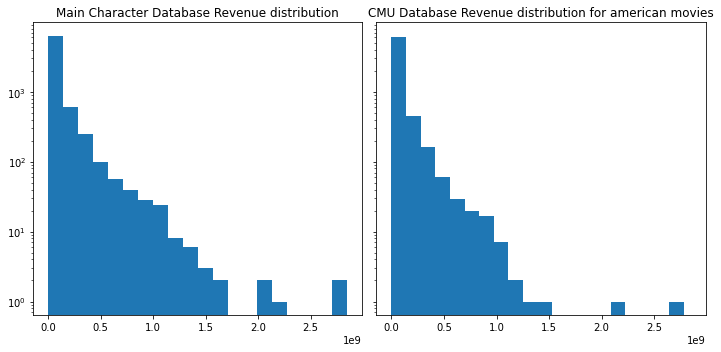

In [128]:
# let us see if the movies_usa database is similar to the main_char movie database by looking at the 
# distribution of their features
# such as revenue, etc. 
# features they have in commun are 'genre', 'revenue', 'languages(doesn't make sense)'

# plot histograms of the revenue of movies in both databases

fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

axs[0].hist(main_char['gross'], bins = 20)
axs[0].set_title('Main Character Database Revenue distribution')
axs[0].semilogy()

axs[1].hist(movies_usa['revenue'], bins = 20)
axs[1].set_title('CMU Database Revenue distribution for american movies')
axs[1].semilogy()   
    
plt.tight_layout()
print("The revenue distribution looks simmilar.")
print("However, the main character database does seem to have more movies with higher revenue.") 

In [129]:
print("Let us check if the different between the revenues is significant.")

# let us first compute the mean
print(f"The mean revenue in the main character database is {main_char['gross'].mean()}.")
print(f"The mean revenue for the movie metadata database for american movies is {movies_usa[movies_usa['release']> '1980-12-06']['revenue'].mean()}")
print(f"On average, the revenue of movies in the main character database is {round(movies_usa['revenue'].mean()/main_char['gross'].mean(),4)*100}% higher than the revenue of cmu movies.")                                                                                                                                              

Let us check if the different between the revenues is significant.
The mean revenue in the main character database is 78500541.01778312.
The mean revenue for the movie metadata database for american movies is 66140256.468948744
On average, the revenue of movies in the main character database is 69.46% higher than the revenue of cmu movies.


In [130]:
# we will use hypothesis testing to see if the revenue of movies in one dataset is bigger than the other
# 'Ho = the distribution is the same' is the hypothesis

print(stats.ttest_ind(main_char['gross'], movies_usa[movies_usa['release']> '1980-12-06']['revenue'], nan_policy='omit'))

Ttest_indResult(statistic=4.506366155618769, pvalue=6.653073527605449e-06)


#### Observations from movie revenue analysis
The p-value is much smaller than 0.05, meaning we can safely reject the null hypothesis that the mean revenues for movies from the two databases are the same.
The value of the test statistic is positive, hence, the mean revenue of movies in the main character dataset is larger.
Therefore, analysis done in this study applies on american movies released after June 1980 with on average high revenue.

## 2.2 - Genre distribution in cmu database versus main character database

Let us investigate more significant differences between the main character dataset we are using and the cmu movie database provided to us for the project. 

The role of the following analysis will be to see if our results can be biased based on the prevalence of certain movie genres in the dataset.

For example, if most movies in the main character database are thrillers, then we can say our analyis mostly applies to thrillers and can be biased for movies of other genres.

In [131]:
# Now get us see if some movie genres are over or under represented in one database compared to the other
# Let us store the genre distribution of the main character movie database in a dataframe

# initialize data frame

# create an array of all the genres 
genres = main_char['genre'].unique()

# initialize data frame
main_char_genres = pd.DataFrame(columns=['movie_number_main_char', 'movie_%_main_char'], 
                  index = [genres])

# fill dataframe with the number and proportion 
for genre in range(len(genres)):
    
    main_char_genres.iat[genre,0] = main_char[main_char['genre']==genres[genre]]['genre'].count()
    main_char_genres.iat[genre,1] = round(main_char_genres.iat[genre,0]/len(main_char)*100,2)
    
main_char_genres.head()

,movie_number_main_char,movie_%_main_char
Drama,1518,19.8
Adventure,427,5.57
Action,1705,22.24
Comedy,2245,29.28
Horror,322,4.2


In [132]:
genres = np.array(['Drama', 'Adventure', 'Action', 'Comedy', 'Horror', 'Biography',
       'Crime', 'Fantasy', 'Family', 'Science Fiction', 'Animation', 'Romance',
       'Music', 'Western', 'Thriller', 'History', 'Mystery', 'Sport',
       'Musical'])

movies_usa_genres = pd.DataFrame(columns=['movie_number_usa', 'movie_%_usa'], 
                  index = [genres])

# fill dataframe with the number and proportion 
for genre in range(len(genres)):
    
    movies_usa_genres.iat[genre,0]=movies_usa[movies_usa['genres'].apply(lambda x: genres[genre] in x)]['genres'].count()
    

for genre in range(len(genres)):
    movies_usa_genres.iat[genre,1]= round(movies_usa_genres.iat[genre,0]/sum(movies_usa_genres['movie_number_usa']) *100,2)

#movies_usa_genres.sort_values(by = 'movie_number')    
movies_usa_genres.head()

,movie_number_usa,movie_%_usa
Drama,13375,18.88
Adventure,5477,7.73
Action,5246,7.4
Comedy,10973,15.49
Horror,3050,4.3


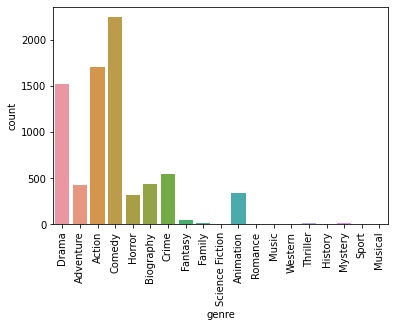

In [133]:
#movies_usa_genres['genre'] = movies_usa_genres.index
# creating the bar plot
ax = sns.countplot(data=main_char, x="genre")
ax.set_xticklabels(labels=genres,rotation=90);

The genre distribution of the two movies looks very different.


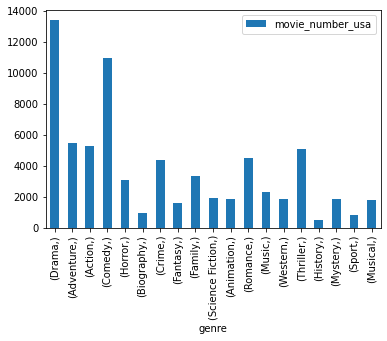

In [134]:
movies_usa_genres['genre']=movies_usa_genres.index
ax = movies_usa_genres.plot.bar(x='genre', y='movie_number_usa', rot=90) 
print("The genre distribution of the two movies looks very different.")

In [135]:
# let us compare the proportions:
genre_compare = pd.concat([movies_usa_genres[['movie_%_usa']] ,main_char_genres[['movie_%_main_char']] ], axis = 1)
genre_compare['movie_%_main_char'][9] = 0.13
genre_compare['difference'] = genre_compare['movie_%_usa']-genre_compare['movie_%_main_char']
genre_compare = genre_compare.sort_values(by ='difference', ascending = 0)
genre_compare.head(19)

,movie_%_usa,movie_%_main_char,difference
Thriller,7.18,0.21,6.97
Romance,6.32,0.13,6.19
Family,4.72,0.14,4.58
Music,3.22,0.01,3.21
Science Fiction,2.74,0.13,2.61
Western,2.63,0.04,2.59
Musical,2.55,0.03,2.52
Mystery,2.61,0.26,2.35
Adventure,7.73,5.57,2.16
Fantasy,2.25,0.57,1.68


#### Observations from genre distribution Analysis
Our analysis dataset has a smaller proportion of drama, thriller, Romance, Family and Science fiction movies than the original dataset, as well has a much much bigger proportion of Action, Comedy, and Biography movies.

Therefore, we can say that our analysis is mostly valid for Action, Comedy and Biography movies, but very innacurate for Thrillers, Romance and Family movies. This is a limitation of our study.

In [136]:
print(f"We are supposed to have about {len(main_char)} movies until the end.")

We are supposed to have about 7668 movies until the end.


In [137]:
# add the main characters to the movies_usa dataset by merge 
main_char.drop(columns = ['runtime'],inplace = True)
movies_usa_lead = pd.merge(movies_usa, main_char, how='inner', left_on='name', right_on='name')
movies_usa_lead.head(1)

,wiki_movieID,freebase_movieID,name,release,revenue,runtime,languages,countries,genres,rating,...,released,score,votes,director,writer,star,country,budget,gross,company
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",R,...,"August 24, 2001 (United States)",4.9,52000.0,John Carpenter,Larry Sulkis,Natasha Henstridge,United States,28000000.0,14010832.0,Screen Gems


In [138]:
print(f"There are {len(movies_usa[movies_usa['release']> '1980-12-06'])-len(main_char[main_char.index<6445])} movies lost when we use the main_char dataset")

There are 11024 movies lost when we use the main_char dataset


In [139]:
print(f"Length after merge: {len(movies_usa_lead)}.")
print(f"We lose {len(main_char[main_char.index<6445]) - len(movies_usa_lead)} movies of missing movies in either dataset or different spelling of the movie title.")

Length after merge: 6151.
We lose 294 movies of missing movies in either dataset or different spelling of the movie title.


In [ ]:
# characters metadata dataset with all characters and their gender
characters_db.head(1)

In [ ]:
characters_db.drop(columns = ['char_name', 'release'], inplace = True)
#characters_db.columns

In [ ]:
movies_usa_gender = pd.merge(movies_usa_lead, characters_db, how = 'inner', right_on= ['wiki_movieID', 'act_name'], left_on = ['wiki_movieID', 'star'])
movies_usa_gender.head(2)

## 2.3 - Are movies genres and gender of the lead role related?

### 2.3.1 - Naïve analysis 

In [ ]:
# let us first build a contingency table for analysis 

gender_contingency = pd.crosstab(movies_usa_gender['gender'], 
                            movies_usa_gender['genre'],
                                margins = False)
gender_contingency.head()

In [ ]:
# let us first visualize this contingency table

X = movies_usa_gender['genre'].unique()
Y_female = gender_contingency.loc['F',:]
Y_male = gender_contingency.loc['M',:]
X_axis = np.arange(len(X))

plt.figure(figsize=(15,4))
plt.bar(X_axis-0.2, Y_female, 0.4, label = 'Female', color = 'orchid')
plt.bar(X_axis+0.2, Y_male, 0.4, label = 'Male', color = 'royalblue')

plt.xticks(X_axis, X, rotation = 90)
plt.xlabel("Genres")
plt.ylabel("Number of lead roles")
plt.title("Lead role gender by movie genre")
plt.legend()
plt.show()

print("It looks like male actors systemacically have a higher chance at the lead role, with the differences depending upon which movie genre we look at. For example, for action movies, men are far more likely to have the lead role than women, whereas in drama movies, this difference is less stark.")

### 2.3.2 - Statistical analysis 
#### Note: 
For some movies genres (Sci-Fi, Family, Thriller, Fantasy, Mysterym, Romance and Western) we don't have enough data points to do a firm analysis, hence, we will drop them and focus our analysis for Drama, Action, Comedy, Crime, Biography, Adventure, Animation and Horror movies. This is a limitation of our study.

In [ ]:
# now let us do more rebust tests with statistical methods
# get us look at the correlation between the gender of the lead role and the genre of a movie

gender_contingency = gender_contingency[['Drama','Action','Comedy','Crime','Biography','Adventure','Animation','Horror']]
genres = gender_contingency.columns
# we will use Cramer's V method to calculate the correlation coefficient between the categorical variables
dataset = np.array(gender_contingency)

X2 = stats.chi2_contingency(dataset, correction=False)[0]
N = np.sum(dataset)
minimum_dimension = min(dataset.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2/N) / minimum_dimension)
print(f"R = {result}")
print("The correlation coefficient R is high enough to investigate further.")

In [ ]:
# let us use the chi-squared test 

dataset = np.array(gender_contingency)

stat, p_value, dof, expected_freq = stats.chi2_contingency(dataset)
print(f"Test statistic = {stat}, p-value = {p_value}")
print("The p-value is much smaller than 0.05, so we can reject the null hypothesis that the gender of the lead actor isn't related genre of the movie. ")

In [ ]:
# now let is try to compare the exèected frequencies and observed frequencies and visualise the difference
# we will plot them side by side 

# creating a new contingency table out of expected frequencies given by the shi-squared test
gender_contingency_x2 = pd.DataFrame(expected_freq, columns = genres, index = ['F','M'])

# converting frequencies into percentages
gender_contingency_x2 = gender_contingency_x2.apply(lambda x: x/sum(x))
gender_contingency = gender_contingency.apply(lambda x: x/sum(x))

# preparing X and Y values for bar plots
X = genres
Y_female = gender_contingency.loc['F',:]
Y_male = gender_contingency.loc['M',:]
X_axis = np.arange(len(X))

Y_female_exp = gender_contingency_x2.loc['F',:]
Y_male_exp = gender_contingency_x2.loc['M',:]

contingency_diff = gender_contingency-gender_contingency_x2
Y_female_diff = contingency_diff.loc['F',:]
Y_male_diff = contingency_diff.loc['M',:]

In [ ]:
# let is visualise the difference between the expected values and the observed values 
# the expected values in a chi-squared test are the values we would expect if the null hypothesis were true
# meaning the frequencies we could expect if the gender of the lead actor and movie genre were not correlated

# plot 
fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].bar(X_axis-0.2, Y_female_exp, 0.4, label = 'Female', color = 'orchid')
ax[0].bar(X_axis+0.2, Y_male_exp, 0.4, label = 'Male', color = 'royalblue')

ax[1].bar(X_axis-0.2, Y_female, 0.4, label = 'Female', color = 'orchid')
ax[1].bar(X_axis+0.2, Y_male, 0.4, label = 'Male', color = 'royalblue')

ax[2].bar(X_axis-0.2, Y_female_diff, 0.4, label = 'Female', color = 'orchid')
ax[2].bar(X_axis+0.2, Y_male_diff, 0.4, label = 'Male', color = 'royalblue')
y = 0*X_axis
ax[2].plot(X_axis,y,'-k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Genres')
ax[0].set_title('Expected Frequencies')
ax[0].set_xticks(X_axis, genres)
ax[0].legend()
ax[1].set_ylabel('Genres')
ax[1].set_title('Observed Frequencies')
ax[1].set_xticks(X_axis, genres)
ax[1].legend()
ax[2].set_ylabel('Genres')
ax[2].set_title('Difference between expected and observed frequencies')
ax[2].set_xticks(X_axis, genres)
ax[2].legend()
plt.tight_layout()

####  Observations:
Without any correlation between the gender of the lead role and movies genre, men are expected to lead ≃ 75% of movies of all genres and women are expected to lead ≃ 25% of movies across all genres(This is because men are generally occupy the main role in movies more often than women). However, the observed values differ from this prediciton. On average, women occupy 25% of the lead roles in movies and men occupy 75% of them.

**Drama Films:** In Drama films, women occupy the lead role ≃ 35% of the time and men ≃ 65% of the time. Comparing with the expected values, this means american cinema is more likely to choose women as lead role in Drama movies than men than average.

**Comedy Films:** In Comedy films, women occupy the lead role ≃ 30% of the time and men ≃ 70% of the time. Comaring with the expected frequencies, american cinema is more likely to choose women as lead role in Comedy movies than men than average.

**Action Films:** In Action films, men occupy the lead role more than 90% of the time while women occupy it less than 10% of the time. Comparing this to the expected values, american cinema is more likely to choose men as their lead role in action movies than average.

**Crime Films:** In Crime films, men occupy the lead role more than 80% of the time while women occupy it less than 20% of the time. Comparing is to the expected frequencies, american cinema is more likely to choose men as their lead role in crime movies on average.

**Biography Films:** In Biography films, men occupy the lead role about 70% of the time while women occupy it about 30% of the time. Comparing this to the expected values, Biography films star women a bit more than average.

**Adventure Films:** In Adventure films, men occupy the lead role more than 70% of the time while women occupy it less than 30% of the time. Comparing this to the expected values, Adventure films star women a bit more than average.

**Horror Films:** Horror films seem to do the best in terms of gender distribution of main roles. Women occupy the lead role 44% of the tie while men occupy it 55% of the time. Comparing this to the expected values, Horror movies are much more likely to portray women than men compared to average.



## 2.4 - Adding the ethnicity of actors (when available)
In this section, we will use the cum character database that has the freebaseID of actor's ethnicty, and match it with the ethnicities in our ethnicity query database that contains the ethnicity corresponding to every freebaseID code.

In [ ]:
## adding ethnicity of every main actor 

# load ethnicity query database containing corresponding ethnicity of every freebaseID code

ethnicity_query = pd.read_csv("MovieSummaries/ethnicity_query.csv",sep=";" )
ethnicity_query.rename(columns = {'name': 'ethnicity_original'}, inplace = True)
ethnicity_query.rename(columns = {'freebaseID': 'ethnicity_freebaseID'}, inplace = True)
ethnicity_query.drop(columns = ['item'], inplace = True)
ethnicity_query.head(1)

In [ ]:
# load characters metadata dataset with all characters and their eithnicity code 
characters_db = pd.read_pickle('MovieSummaries/characters_db.pickle')
characters_db.head(1)

In [ ]:
# add correct ethnicity in characters_db instead of code with help of ethnicity_query table

characters_db = pd.merge(characters_db, ethnicity_query, how='inner', left_on='ethnicity', right_on='ethnicity_freebaseID')
characters_db.drop(columns = ['ethnicity_x'], inplace = True)
characters_db.rename(columns = {'ethnicity_y': 'ethnicity'}, inplace = True)
characters_db.drop(columns = ['height'], inplace = True)
characters_db.head(1)

In [ ]:
characters_db.drop(columns = ['char_name', 'release'], inplace = True)

In [ ]:
print(len(movies_usa_lead))
movies_usa_ethnicity = pd.merge(movies_usa_lead, characters_db, how = 'inner', right_on= ['wiki_movieID', 'act_name'], left_on = ['wiki_movieID', 'star'])
print(len(movies_usa_ethnicity))
movies_usa_ethnicity.head(1)

#### Observations 
We notice here that we go from a dataset of 6151 movies to a dataset of 1741 movies by merging characters_db and movies_usa_lead. This is because of the ethnicity column. Movies are un-able to merge and lost because of two reasons. Either the ethnicity of the actor was not available in the characters_db dataset. Or the freebaseID ethnicity code in characters_db  didn't correspond to any codes in our query table. We will however continue our analysis on ethnicity of lead roles in american movies.

In [ ]:
# build contingency table for movie genres and ethnicity of main actors 

ethnicity_contingency = pd.crosstab(movies_usa_ethnicity['genre'], 
                            movies_usa_ethnicity['ethnicity'],
                                margins = False)
ethnicity_contingency.head()

In [ ]:
# drop columns with very small number of data points
ethnicity_contingency.drop(index = ['Thriller','Romance', 'Sci-Fi','Mystery','Fantasy','Family'], inplace = True)

# aggregate Asian ethnicity columns 
ethnicity_contingency['Asian'] = ethnicity_contingency['East Asian']+ ethnicity_contingency['Indo-Aryan']+ethnicity_contingency['South Asian']+ ethnicity_contingency['South-East Asian']+ ethnicity_contingency['West Asian']

# drop useless Asian ethnicity columns
ethnicity_contingency.drop(columns = ['East Asian','Indo-Aryan','South Asian','South-East Asian','West Asian'], inplace = True)

# put native pacific islander ethnicit with 'others'
ethnicity_contingency['Other'] = ethnicity_contingency['Other']+ethnicity_contingency['Native Pacific Islander']
ethnicity_contingency.drop(columns = ['Native Pacific Islander'], inplace = True)

# put multiracial Amercian ethnicity with 'other'
ethnicity_contingency['Other'] = ethnicity_contingency['Other']+ethnicity_contingency['Multiracial American']
ethnicity_contingency.drop(columns = ['Multiracial American'], inplace = True)

ethnicity_contingency = ethnicity_contingency.transpose()

ethnicity_contingency.head(8)

In [ ]:
# let us first visualize this contingency table

ax = ethnicity_contingency.plot.bar(rot=90, figsize = (20,5))
ax.semilogy()

### 2.4.1 - Statistical analysis 

In [ ]:
# now let us do more rebust tests with statistical methods
# get us look at the correlation between the gender of the lead role and the genre of a movie

genres = ethnicity_contingency.columns
# we will use Cramer's V method to calculate the correlation coefficient between the categorical variables
dataset_eth = np.array(ethnicity_contingency)

X2_eth = stats.chi2_contingency(dataset_eth, correction=False)[0]
N = np.sum(dataset_eth)
minimum_dimension = min(dataset_eth.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((X2_eth/N) / minimum_dimension)
print(f"R = {result}")

In [ ]:
# chi-squared test
dataset_eth = np.array(ethnicity_contingency)

stat_eth, p_value_eth, dof_eth, expected_freq_eth = stats.chi2_contingency(dataset_eth)
print(f"Test statistic = {stat_eth}, p-value = {p_value_eth}")

In [ ]:
pd.DataFrame(expected_freq_eth, index = ethnicity_contingency.index, columns = ethnicity_contingency.columns).apply(lambda x: x/sum(x))

The p-value of the chi-square test is much smaller than 0.05, hence, we can reject the null hypothesis that there is no relationship between the ethnicity of the main actor and genre of the movie. Let us investigate further. We will compare the expected frequencies with the observed frequencies of the number of actors for the lead of a movie by genre per ethnicity.

In [ ]:
# converting expected frequencies into percentages
exp = pd.DataFrame(expected_freq_eth, index = ethnicity_contingency.index, columns = ethnicity_contingency.columns).apply(lambda x: x/sum(x))

# plotting the expected frequencies
ax1 = exp.plot.bar(rot=90, figsize = (20,5))
ax1.semilogy()
ax1.set_title('Expected Frequencies')

# converting observed frequencies into percentages
obs = pd.DataFrame(ethnicity_contingency).apply(lambda x: x/sum(x))

# plotting the observed frequencies
ax2= obs.plot.bar(rot=90, figsize = (20,5))
ax2.semilogy()
ax2.set_title('Observed Frequencies')

# getting difference between observed and expected frequencies in percentage
y = 0*X_axis
diff_eth = obs - exp

# plotting the difference
ax3= diff_eth.plot.bar(rot=90, figsize=(20,6))
ax3.plot(X_axis*2,y,'-k')
ax3.set_title('Difference between observed and expected frequencies')
ax3.legend(loc='upper right')

# 3 - Gender of the crew

## 3.1 - Data preprocessing
First, we need to process the data to get a dataframe that also contains the crew information.

In [ ]:
# Merge ImDB crew and movie info
crew_title = pd.merge(crew_basic, movie_basics, on = 'tconst')
crew_title.rename(columns = {'primaryTitle': 'name'}, inplace = True)

# Duplicates in the crew_title dataset are deleted
# Still difference with number of unique names -> group by name by aggregating to a list the other info
crew_title = crew_title[['name', 'directors', 'writers']].drop_duplicates().groupby("name").aggregate(lambda x: tuple(x))
movies_crew = movies_usa.merge(crew_title, on = 'name', how = 'inner')
movies_crew = movies_crew.dropna()

# Add gender to name dataset - 
# Use of the ImdB dataset to get info on director and not just use of the directors_sex because it hase multiple 
# directors per movies and contains info on writers as well. Also, it is a more reliable source
directors_sex.rename(columns = {'director': 'primaryName'}, inplace = True)
name_genders = pd.merge(name_basics, directors_sex[['primaryName', 'gender']], on = 'primaryName')

In [ ]:
movies_crew.head(1)

In [ ]:
# Print info possibly lost 
print(f'Total movies at beginning: {len(movies_db)}')
print(f'Total american movies: {len(movies_usa)}')
print(f'After merge with crew info: {len(movies_crew)}')
print(f'\nSamples lost to have info on crew/director: {len(movies_usa) - len(movies_crew)}')

In [ ]:
# Add the presence of at least one women or all women in crew to DataFrame
women = name_genders[name_genders['gender']=='female']['nconst']
movies_crew['dir_one_fem'] = movies_crew['directors'].progress_apply(
    lambda x: any(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

In [ ]:
movies_crew['dir_all_fem'] = movies_crew['directors'].progress_apply(
    lambda x: all(const_women == const_dir
                  for directors in x
                  for const_dir in directors.split(',')
                  for const_women in women
                 )) 

In [ ]:
movies_crew['wri_one_fem'] = movies_crew['writers'].progress_apply(
    lambda x: any(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

In [ ]:
movies_crew['wri_all_fem'] = movies_crew['writers'].progress_apply(
    lambda x: all(const_women == const_wri
                  for writers in x
                  for const_wri in writers.split(',')
                  for const_women in women
                 )) 

In [ ]:
movies_crew.head(1)

## 3.2 -  Does the proportion of movies with women in the crew change with time ?

### 3.2.1 - Yearly means

In [ ]:
# Extract the year out of the date 
movies_crew['year'] = pd.to_datetime(movies_crew['release']).apply(lambda x: x.year)
movies_crew = movies_crew.dropna()

In [ ]:
# Build specific DataFrames
# For this part, wa refers to at least one woman, w to all women, m to all men
# In terms of the directors
movies_dir_wa = movies_crew[movies_crew['dir_one_fem']==True]
movies_dir_w = movies_crew[movies_crew['dir_all_fem']==True]
movies_dir_m = movies_crew[movies_crew['dir_one_fem']==False]
# In terms of the writers
movies_wri_wa = movies_crew[movies_crew['wri_one_fem']==True]
movies_wri_w = movies_crew[movies_crew['wri_all_fem']==True]
movies_wri_m = movies_crew[movies_crew['wri_one_fem']==False]
# In terms of whole crew 
movies_crew['crew_one_fem'] = movies_crew['wri_one_fem'].apply(lambda x: int(x)) + movies_crew['dir_one_fem'].apply(lambda x: int(x)) > 0
movies_wa = pd.concat([ movies_crew[movies_crew['wri_one_fem']==True] , movies_crew[movies_crew['dir_one_fem']==True]])
movies_w = movies_crew[movies_crew['wri_all_fem']==True][movies_crew['dir_all_fem']==True]
movies_m = movies_crew[movies_crew['wri_one_fem']==False][movies_crew['dir_one_fem']==False]

In [ ]:
tot = len(movies_crew)
# Check proportions of women directors
print('Number of movies directed by all women: ' + f"{len(movies_dir_w)}" + " == " + "{:.2%}".format(len(movies_dir_w) / tot) + " of total movies in dataset")
print('Number of movies directed by at least one woman: ' + f"{len(movies_dir_wa)}" + " == " + "{:.2%}".format(len(movies_dir_wa) / tot) + " of total movies in dataset")
print('Number of movies directed by all men: ' + f"{len(movies_dir_m)}" + " == " + "{:.2%}".format(len(movies_dir_m) / tot) +  " of total movies in dataset")

# Check proportions of women writters
print('\nNumber of movies written by all women: ' + f"{len(movies_wri_w)}" + " == " + "{:.2%}".format(len(movies_wri_w) / tot) + " of total movies in dataset")
print('Number of movies written by at least one woman: ' + f"{len(movies_wri_wa)}" + " == " + "{:.2%}".format(len(movies_wri_wa) / tot) + " of total movies in dataset")
print('Number of movies written by all men: ' + f"{len(movies_wri_m)}" + " == " + "{:.2%}".format(len(movies_wri_m) / tot) + " of total movies in dataset")

# Check proportions of women crew members
print('\nNumber of movies written and directed by women: ' + f"{len(movies_w)}" + " == " + "{:.2%}".format(len(movies_w) / tot) + " of total movies in dataset")
print('Number of movies written and directed by at least one woman: ' + f"{len(movies_wa)}" + " == " + "{:.2%}".format(len(movies_wa) / tot) + " of total movies in dataset")
print('Number of movies written and directed by all men: ' + f"{len(movies_m)}" + " == " + "{:.2%}".format(len(movies_m) / tot) + " of total movies in dataset")

### 3.2.2 - Plot the yearly evolution

In [ ]:
# yearly releases of movies 
tot = movies_crew.groupby('year').aggregate('count')['wiki_movieID']
# Yearly releases of movies directed by men/women 
plot_w_d = movies_crew.groupby('year').aggregate(sum)['dir_all_fem'] 
plot_wa_d = movies_crew.groupby('year').aggregate(sum)['dir_one_fem']  
# Yearly releases of movies written by men/women 
plot_w_w = movies_crew.groupby('year').aggregate(sum)['wri_all_fem']
plot_wa_w = movies_crew.groupby('year').aggregate(sum)['wri_one_fem']  
# Yearly releases of movies containing at least one woman in the crew
plot_wa = movies_crew.groupby('year').aggregate(sum)['crew_one_fem']  
plot_m = tot - plot_wa

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_wa_d.index, y=plot_wa_d/tot*100, name='At least one woman director',
                         line=dict(color='#72B7B2', width=4)))

fig.add_trace(go.Scatter(x=plot_wa_w.index, y=plot_wa_w/tot*100, name='At least one woman writer',
                         line=dict(color='#9467BD', width=4, dash='dot')))


fig.add_trace(go.Scatter(x=plot_wa.index, y=plot_wa/tot*100, name='At least one woman in the crew',
                         line=dict(color='#E45756', width=4, dash='dash')))

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

### 3.2.3 -  Statstical tests
To look at the impact of the gender on the number of movies we will use the Mann Whitney U test. The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [ ]:
# Check if the distribution of the number of movies created by men is different than the distribution of movies
# that have at least one woman in the crew
result = stats.mannwhitneyu(plot_wa, plot_m)
print(result)
print('The p-value is under 0.05 so there we can significantly reject the null hypothesis. \nThe two distributions are statistically different.')

In [ ]:
# Check if the proportion of women in the crew changes with time 

# 4 - Revenue comparisons 

Finally, we will answer these questions: 

Is there a noticeable difference in revenue for movies that portray some particular genre? Is there a noticeable difference in revenue for movies created by women ?

We will not look at the statistical difference for ethnicities as there are not enough minorities samples. However, the impact of main character being white or not will be measured in part 4.3. 

To look at the impact of the gender on the revenue we will use the Mann Whitney U test. The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

## 4.1 - In terms of the gender of the main actor

## 4.2 - In terms of the gender of the crew

### 4.2.1 - Naïve approach

In [ ]:
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(movies_crew, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')

fig.show()

### 4.2.2 - Matching revenue with budget

In [ ]:
movies_budget = pd.merge(movies_crew, mainchar_budget[['name', 'budget']], on = 'name').dropna()

In [ ]:
# Info lost 
print(f'Total movies at beginning: {len(movies_crew)}')
print(f'After merge with budget info: {len(movies_budget)}')
print(f'\nSamples lost to have info on budget: {len(movies_crew) - len(movies_budget)}')

In [ ]:
# Correlation between budget and revenue
result = stats.pearsonr(movies_budget['revenue'], movies_budget['budget'])
print(result)
print('p-vaue is below 0.05. \nThere is a significant positive correlation between the revenue and the budget. \nMatching on the budget to study the revenue makes sense.')

In [ ]:
# Preprocess movie_budget df
movies_budget = movies_budget.dropna()
movies_budget['dir_one_fem'] = movies_budget['dir_one_fem'].apply(lambda x: int(x))
print(movies_budget.columns)

In [ ]:
# Separate in the two groups to be matched (at least one women, only men)
wa = movies_budget[movies_budget['crew_one_fem'] == 1]
m = movies_budget[movies_budget['crew_one_fem'] == 0]

In [ ]:
# Loop through all the pairs of instances
for m_id, m_row in m.iterrows():
    k = -1
    for wa_id, wa_row in wa.iterrows():
        k = k+1 
        if abs(wa_row['budget'] - m_row['budget']) < 0.1 * m_row['budget']:
            # Add the matched pair to the matched dataframe 
            matched_df = matched_df.append(m_row) 
            matched_df = matched_df.append(wa_row)

In [ ]:
print(len(matched_df))

In [ ]:
matched_df.head(2)   

### 4.2.3 - Plots

In [ ]:
# Plot revenue distribution comparison between gender of the crew
fig = px.histogram(matched_df, x="revenue", color="crew_one_fem", log_y=True)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

# Edit the layout
fig.update_layout(title='Percentage of movies with women in the crew through the years',
                   xaxis_title='Year',
                   yaxis_title='Percentage of movies')
fig.show()

### 4.2.4 - Statistical tests

In [ ]:
# Correlation between gender of crew and revenue
revenue_F = matched_df[matched_df['crew_one_fem']==1]['budget']
revenue_M = matched_df[matched_df['crew_one_fem']==0]['budget']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('AFTER MATCHING')
print(result)
print('p-value smaller than 0.05 so we can reject the null hypthesis. \nThe distribution of the revenue is different if the crew contains a woman or not.') 

# Results before matching
revenue_F = movies_crew[movies_crew['crew_one_fem']==1]['budget']
revenue_M = movies_crew[movies_crew['crew_one_fem']==0]['budget']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('\nBEFORE MATCHING')
print(result)

In [ ]:
# Correlation between gender of crew and revenue
revenue_F = matched_df[matched_df['crew_one_fem']==1]['revenue']
revenue_M = matched_df[matched_df['crew_one_fem']==0]['revenue']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('AFTER MATCHING')
print(result)
print('p-value smaller than 0.05 so we can reject the null hypthesis. \nThe distribution of the revenue is different if the crew contains a woman or not.') 

# Results before matching
revenue_F = movies_crew[movies_crew['crew_one_fem']==1]['revenue']
revenue_M = movies_crew[movies_crew['crew_one_fem']==0]['revenue']
result = stats.mannwhitneyu(revenue_F, revenue_M)
print('\nBEFORE MATCHING')
print(result)

## 4.3 - OLS to predict the revenue

In [ ]:
print(matched_df.columns)
print(mainchar_budget.columns)
print(movies_usa_ethnicity.columns)

In [ ]:
ols_df = pd.merge(mainchar_budget[['name', 'genre']], matched_df, on='name')
ols_df = pd.merge(movies_usa_ethnicity[['name', 'ethnicity']], ols_df, on='name')

genres = ols_df['genre'].unique()
genres_dummies = pd.get_dummies(ols_df['genre'])

ethinicity_dummies = pd.get_dummies(ols_df['ethnicity'])

ols_df = pd.concat([ols_df, genres_dummies, ethinicity_dummies['White']], axis = 1)
ols_df.head(1)

In [ ]:
print(ols_df['genre'].unique())

In [81]:
# Perform an ordinary least squares linear regression
test_df = ols_df.copy()
test_df['revenue'] = pd.to_numeric(test_df['revenue'])
test_df['budget'] = pd.to_numeric(test_df['budget'])
test_df['year'] = pd.to_numeric(test_df['year'])
test_df['Action'] = pd.to_numeric(test_df['Action'])

results = smf.ols('revenue ~ budget + crew_one_fem + year + White + Action + Adventure + Drama + Animation + Comedy + Horror', data=test_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     15.28
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           7.95e-19
Time:                        12:54:21   Log-Likelihood:                -4252.6
No. Observations:                 210   AIC:                             8525.
Df Residuals:                     200   BIC:                             8559.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3.872e+09   1.26e+09     -3.083      0.002   -6.35e+09    -1.4e+09
crew_one_fem[T.True]  4.259e+07   2.27e+07      1.872      0.063   -2.26e+06    8.75e+07
budget                 8.58e+07   1.07e+07      7.985      0.000    6.46e+07    1.07e+08
year                  1.974e+06   6.28e+05      3.144      0.002    7.36e+05    3.21e+06
Action               -2.999e+07   3.93e+07     -0.763      0.446   -1.07e+08    4.75e+07
Adventure            -1.295e+08    5.7e+07     -2.273      0.024   -2.42e+08   -1.72e+07
Drama                -2.043e+07   4.43e+07     -0.461      0.645   -1.08e+08     6.7e+07
Animation             9.942e+07      5e+07      1.989      0.048    8.71e+05    1.98e+08
Comedy               -3.741e+07   4.11e+07     -0.910      0.364   -1.18e+08    4.37e+07
Horror               -6.885e+07   6.83e+07     -1.008      0.315   -2.04e+08    6.58e+07
==============================================================================
Omnibus:                       94.765   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.768
Skew:                           1.689   Prob(JB):                    3.00e-109
Kurtosis:                       9.760   Cond. No.                     2.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""